# Zero to Hero

## 2.01 Optimizacion Bayesiana

In [ ]:
El objetivo es mostrar como funciona la Optimizacion Bayesiana en el caso mas simple : una funcion univariada

### Advertencia

El uso del método de Optimización Bayesiana para la optimización de hiperparámetros en modelos predictivos tiene menos de una década.
Entender los fundamentos de la O.B. requieren de una sólida formación matemática y **no** son el objetivo de esta asignatura.
Para quienes deseen aventurarse a los detalles técnicos:
* El paper original de la libreria mlrMBO (año 2018 )   https://arxiv.org/pdf/1703.03373.pdf
* El método de Kriging , tal cual se deriva del uso original, en este pequeño libro de 106 páginas "Basic Steps in Geostatistics: The Variogram and Kriging" https://www.pdfdrive.com/basic-steps-in-geostatistics-the-variogram-and-kriging-e187336318.html

### El código

In [1]:
#Ejemplo de optimizacion bayesiana, univariada

#limpio la memoria
rm( list=ls() )  #remove all objects
gc()             #garbage collection

require("data.table")
#paquetes necesarios para la Bayesian Optimization
require("DiceKriging")
require("mlrMBO")

options(repr.plot.width=20, repr.plot.height=10)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,613799,32.8,1329575,71.1,1088735,58.2
Vcells,1149604,8.8,8388608,64.0,1801045,13.8


Loading required package: data.table

Loading required package: DiceKriging

Loading required package: mlrMBO

Loading required package: mlr

Loading required package: ParamHelpers

Warning message: 'mlr' is in 'maintenance-only' mode since July 2019.
Future development will only happen in 'mlr3'
(<https://mlr3.mlr-org.com>). Due to the focus on 'mlr3' there might be
uncaught bugs meanwhile in {mlr} - please consider switching.

Loading required package: smoof

Loading required package: checkmate


Attaching package: ‘checkmate’


The following object is masked from ‘package:DiceKriging’:

    checkNames




### Defino la funcion a optimizar, un polinomio de grado 4

In [2]:
func_univariada01  <- function( x )
{
  y  <- -2 * (x+13) * (x-3) * (x-7) * (x-19)

  return( y )
}

Grafico la funcion

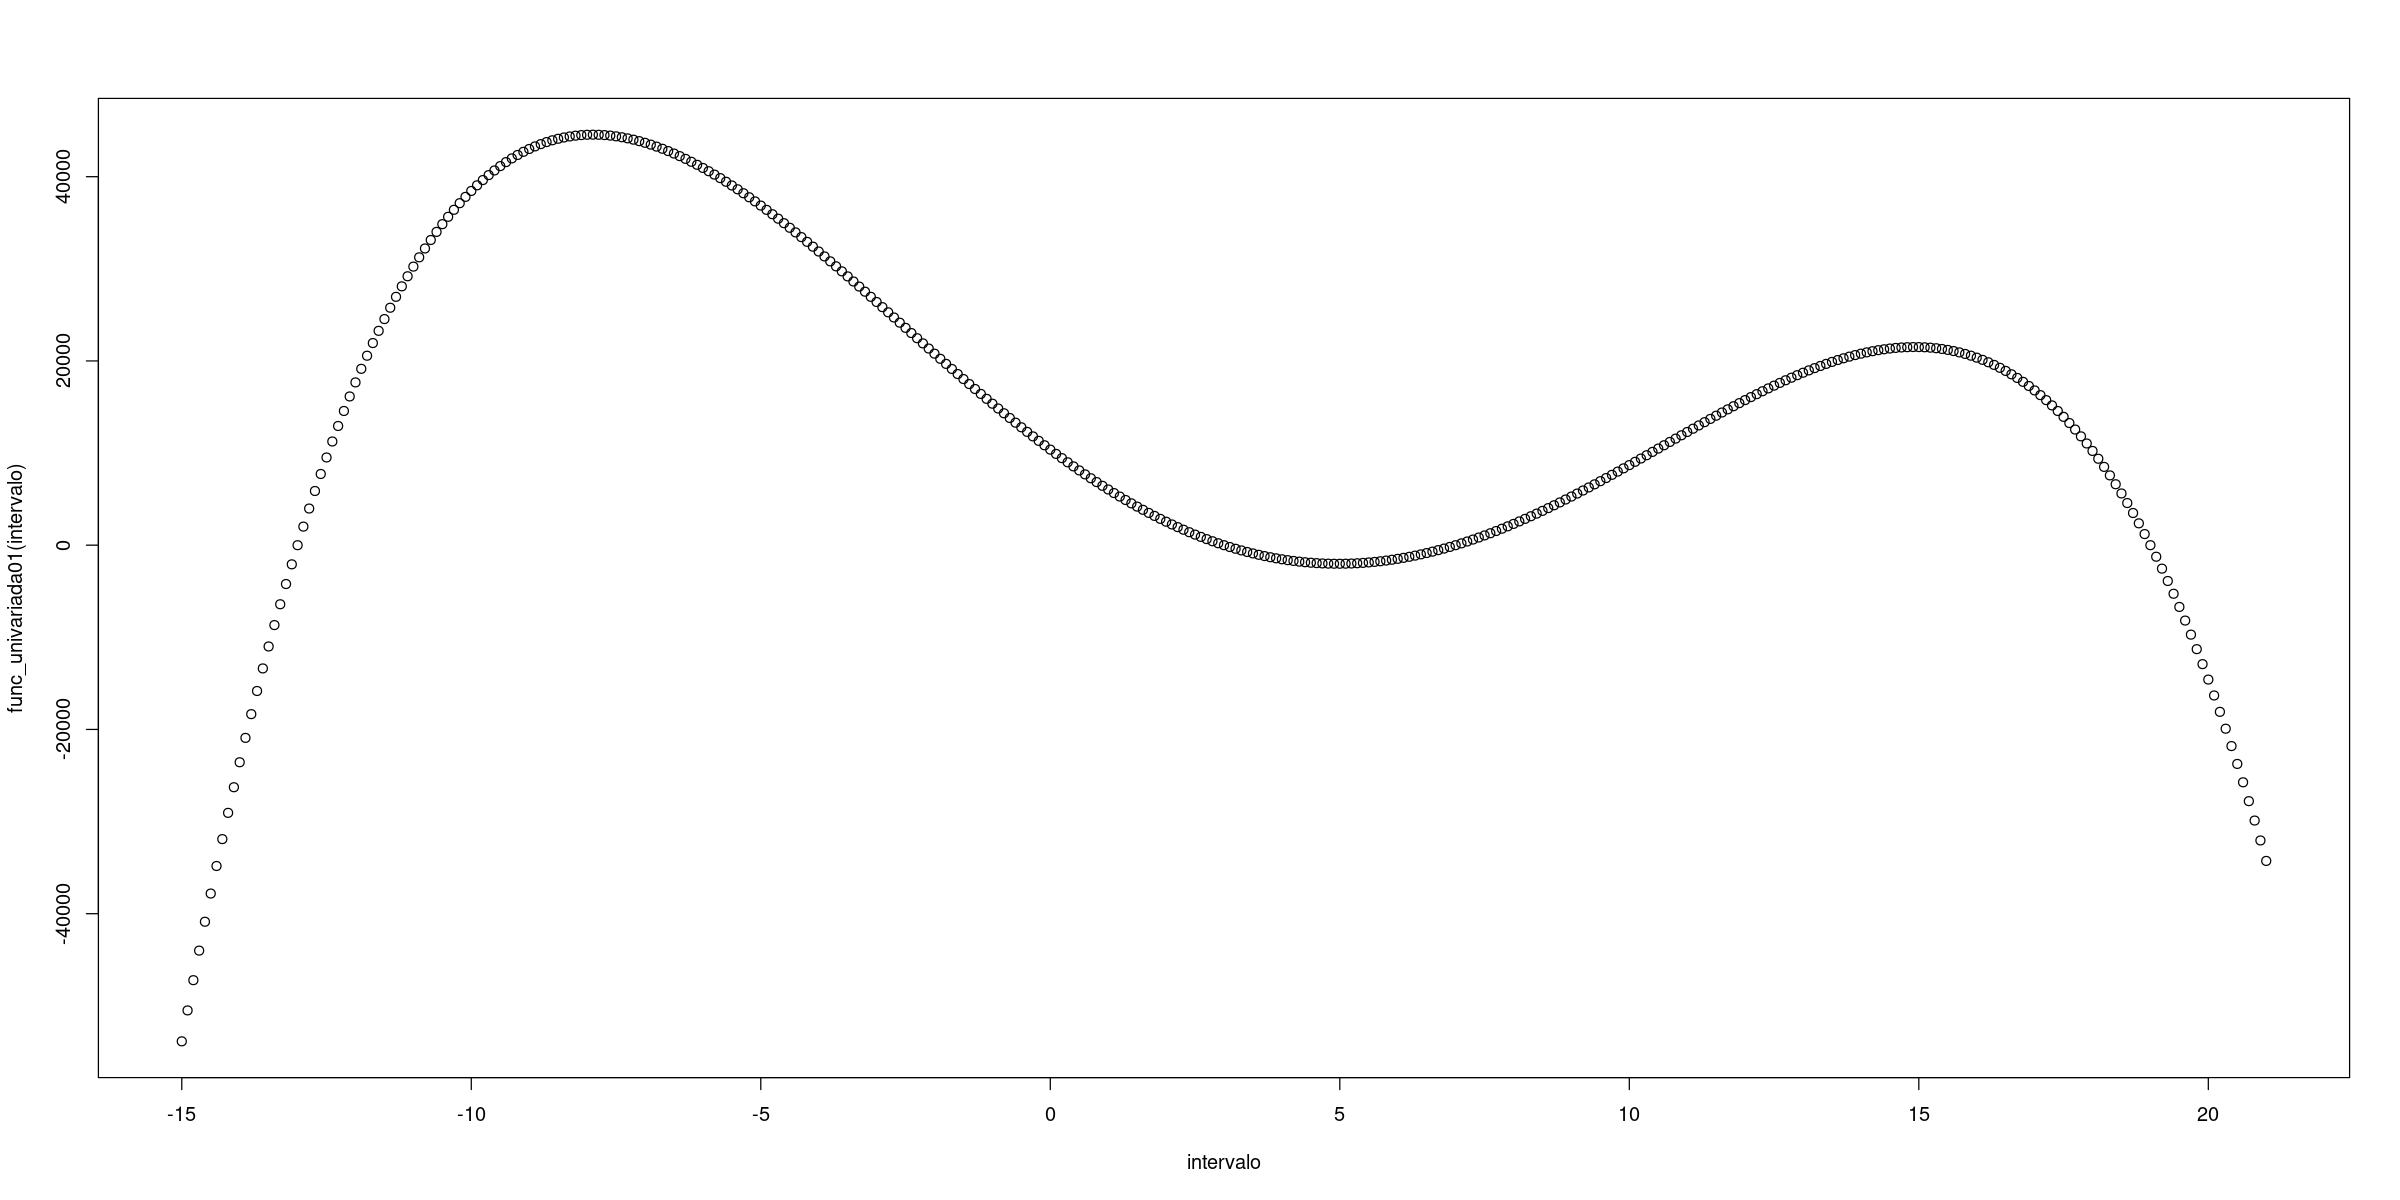

In [4]:
intervalo  <- seq(-15,21,0.1)
plot(intervalo, func_univariada01(intervalo))

La funcion tiene dos máximos, uno de ellos es el global.

### Optimizacion Bayesiana

¿Qué tan rápido encontrará la Optmización Bayesiana el máximo global?

Defino las caracteristicas de la optimizacion

* **fn**    es el nombre de la funcion
* **minimize**   por defecto es TRUE,  pero en este caso le asigno FALSE, ya que deseo maximizar  el valor
* **par.set**  indica cuales son los hiperparmetros de la funcion, en este caso hay una sola variable que llamé  x
---
* **makeNumericParam** indica que ese hiperparámetro es un numero real, una variable continua  ( no es ni un entero ni una categoria )

In [5]:
obj.fun  <- makeSingleObjectiveFunction(
              fn=       func_univariada01,
              minimize= FALSE,   #estoy Maximizando la ganancia
              par.set=  makeParamSet(  makeNumericParam( "x", lower= -100, upper=  100) ),
             )

ahora defino la funcion proxy, la que se construye internamente intentando emular la realidad

* **cl**  es la clase de learner,  "reg.km" indica el método de kriging "**reg**ression **k**riging **m**ethodd"
* **predict.type**  es el tipo de prediccion que deseo me devuelva, "se" significa que espero dos valores  media y standard error
* **covtype**    es la funcion de covarianza que se va a utilizar, cual es la covarianza de dos mediciones como fucion de la distancia entre los puntos donde fueron tomadas las mediciones, fue inventada por Bertil Matérn 

El método de kriging puede verse en su forma original (la geología) , esta presentación https://www.youtube.com/watch?v=ZB7GvJrNKq0

In [6]:
fproxy  <- makeLearner( cl= "regr.km",
                        predict.type= "se", 
                        covtype= "matern3_2" )

ultima definicion,  especificar la optimizacion bayesiana
*  **crit**   indica el criterio con el que se completan los valores iniciales "no inteligentes"
*  **iters**  indica la cantidad de iteraciones inteligentes que hará la Optimizacion Bayesiana, las que son adicionales a las primeras cuatro de este caso.*  **iters**  indica la cantidad de iteraciones inteligentes que hará la Optimizacion Bayesiana, las que son adicionales a las primeras cuatro de este caso.

In [7]:
ctrl  <- makeMBOControl()
ctrl  <- setMBOControlInfill( ctrl, crit= makeMBOInfillCritEI())
ctrl  <- setMBOControlTermination( ctrl, iters= 25 )

finalmente , lanzo la Optimizacion Bayesiana

* **fun**  es la especificacion de la funcion que deseo optimizar, si maximizo o minimizo, cuales son las variables de la misma
* **learner**  especifica cual es la función proxy interna que va a utilizar la Optimziación Bayesiana
* **control**  indica la la forma en que se harán las iteraciones

In [8]:
run  <- mbo( fun=      obj.fun, 
             learner= fproxy, 
             control= ctrl )

Computing y column(s) for design. Not provided.

[mbo] 0: x=93.4 : y = -1.24e+08 : 0.0 secs : initdesign

[mbo] 0: x=-85 : y = -1.21e+08 : 0.0 secs : initdesign

[mbo] 0: x=25.3 : y = -1.97e+05 : 0.0 secs : initdesign

[mbo] 0: x=-20.6 : y = -3.89e+05 : 0.0 secs : initdesign




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  356.8438 
  - best initial criterion value(s) :  -77.53009 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        77.53  |proj g|=     0.010503
At iterate     1  f =        77.53  |proj g|=      0.010502
At iterate     2  f =       77.389  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 77.389

F = 77.389
final  value 77.388960 
converged


[mbo] 1: x=-27.2 : y = -1.36e+06 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  356.8438 
  - best initial criterion value(s) :  -94.96452 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       94.965  |proj g|=    0.0023249
At iterate     1  f =       94.965  |proj g|=     0.0023236
At iterate     2  f =        94.96  |proj g|=    0.00036936
At iterate     3  f =        94.96  |proj g|=    4.7404e-05
At iterate     4  f =        94.96  |proj g|=    8.2384e-07
At iterate     5  f =        94.96  |proj g|=    1.8814e-09

iterations 5
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 1.8814e-09
final function

[mbo] 2: x=6.66 : y = -603 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  356.8438 
  - best initial criterion value(s) :  -112.5961 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        112.6  |proj g|=   0.00071613
At iterate     1  f =        112.6  |proj g|=    0.00071587
At iterate     2  f =        112.6  |proj g|=    3.3951e-05
At iterate     3  f =        112.6  |proj g|=    1.7084e-06
At iterate     4  f =        112.6  |proj g|=    4.3521e-09

iterations 4
function evaluations 5
segments explored during Cauchy searches 4
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 4.35209e-09
final function value 112.595

F = 112.595
final  value 112.595395 
conver

[mbo] 3: x=16.9 : y = 1.73e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  356.8438 
  - best initial criterion value(s) :  -128.829 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       128.83  |proj g|=   0.00078763
At iterate     1  f =       128.83  |proj g|=    0.00078752
At iterate     2  f =       128.83  |proj g|=    8.3186e-05
At iterate     3  f =       128.83  |proj g|=    7.6764e-06
At iterate     4  f =       128.83  |proj g|=    6.6989e-08

iterations 4
function evaluations 5
segments explored during Cauchy searches 4
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 6.69892e-08
final function value 128.827

F = 128.827
final  value 128.826997 
converg

[mbo] 4: x=-6.34 : y = 4.21e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  356.8438 
  - best initial criterion value(s) :  -145.0174 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       145.02  |proj g|=   7.8623e-05
At iterate     1  f =       145.02  |proj g|=    7.8616e-05

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 7.86156e-05
final function value 145.017

F = 145.017
final  value 145.017386 
converged


[mbo] 5: x=0.00967 : y = 1.03e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  356.8438 
  - best initial criterion value(s) :  -160.0847 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       160.08  |proj g|=   0.00016278
At iterate     1  f =       160.08  |proj g|=    0.00016277

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.00016277
final function value 160.085

F = 160.085
final  value 160.084725 
converged


[mbo] 6: x=-12.8 : y = 3.18e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  356.8438 
  - best initial criterion value(s) :  -175.0714 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       175.07  |proj g|=    0.0018692
At iterate     1  f =       175.07  |proj g|=     0.0018691
At iterate     2  f =       175.05  |proj g|=    0.00036744
At iterate     3  f =       175.05  |proj g|=    9.0592e-05
At iterate     4  f =       175.05  |proj g|=    6.1512e-06
At iterate     5  f =       175.05  |proj g|=    1.1232e-07
At iterate     6  f =       175.05  |proj g|=    1.4252e-10

iterations 6
function evaluations 7
segments explored during Cauchy searches 6
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
no

[mbo] 7: x=21.3 : y = -4.23e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  356.8438 
  - best initial criterion value(s) :  -189.4559 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       189.46  |proj g|=   0.00041472
At iterate     1  f =       189.46  |proj g|=    0.00041471

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.00041471
final function value 189.456

F = 189.456
final  value 189.455914 
converged


[mbo] 8: x=11.8 : y = 1.51e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  356.8438 
  - best initial criterion value(s) :  -203.7654 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       203.77  |proj g|=   0.00033648
At iterate     1  f =       203.77  |proj g|=    0.00033647

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000336471
final function value 203.765

F = 203.765
final  value 203.765364 
converged


[mbo] 9: x=-9.57 : y = 4.08e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  356.8438 
  - best initial criterion value(s) :  -217.4363 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       217.44  |proj g|=   0.00016115
At iterate     1  f =       217.44  |proj g|=    0.00016115

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000161148
final function value 217.436

F = 217.436
final  value 217.436283 
converged


[mbo] 10: x=-3.16 : y = 2.73e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  356.8438 
  - best initial criterion value(s) :  -230.9522 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       230.95  |proj g|=   0.00062635
At iterate     1  f =       230.95  |proj g|=    0.00062633

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000626334
final function value 230.952

F = 230.952
final  value 230.952195 
converged


[mbo] 11: x=3.38 : y = -708 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  356.8438 
  - best initial criterion value(s) :  -244.4417 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       244.44  |proj g|=   0.00038076
At iterate     1  f =       244.44  |proj g|=    0.00038075

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000380752
final function value 244.442

F = 244.442
final  value 244.441710 
converged


[mbo] 12: x=14.4 : y = 2.12e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  356.8438 
  - best initial criterion value(s) :  -257.5742 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       257.57  |proj g|=   0.00083767
At iterate     1  f =       257.57  |proj g|=    0.00083765
At iterate     2  f =       257.57  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 257.569

F = 257.569
final  value 257.569227 
converged


[mbo] 13: x=-15.9 : y = -8.94e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  356.8438 
  - best initial criterion value(s) :  -271.2162 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       271.22  |proj g|=    0.0019182
At iterate     1  f =       271.22  |proj g|=     0.0019181
At iterate     2  f =       271.17  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 271.174

F = 271.174
final  value 271.173968 
converged


[mbo] 14: x=9.26 : y = 6.12e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  356.8438 
  - best initial criterion value(s) :  -284.1827 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       284.18  |proj g|=    0.0018852
At iterate     1  f =       284.18  |proj g|=     0.0018852
At iterate     2  f =       284.17  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 284.172

F = 284.172
final  value 284.172294 
converged


[mbo] 15: x=-7.96 : y = 4.46e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  356.8438 
  - best initial criterion value(s) :  -296.5659 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       296.57  |proj g|=    0.0025563
At iterate     1  f =       296.57  |proj g|=     0.0025562
At iterate     2  f =       296.54  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 296.541

F = 296.541
final  value 296.541089 
converged


[mbo] 16: x=18.9 : y = 939 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  356.8438 
  - best initial criterion value(s) :  -309.3992 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=        309.4  |proj g|=    0.0037844
At iterate     1  f =        309.4  |proj g|=     0.0037842
At iterate     2  f =       309.31  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 309.306

F = 309.306
final  value 309.306027 
converged


[mbo] 17: x=-4.78 : y = 3.58e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  356.8438 
  - best initial criterion value(s) :  -321.5613 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       321.56  |proj g|=    0.0034908
At iterate     1  f =       321.56  |proj g|=     0.0034907
At iterate     2  f =       321.54  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 321.541

F = 321.541
final  value 321.540899 
converged


[mbo] 18: x=-11.1 : y = 2.93e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  356.8438 
  - best initial criterion value(s) :  -333.8112 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       333.81  |proj g|=    0.0040795
At iterate     1  f =       333.81  |proj g|=     0.0040793
At iterate     2  f =       333.78  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 333.782

F = 333.782
final  value 333.781824 
converged


[mbo] 19: x=-1.6 : y = 1.86e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  356.8438 
  - best initial criterion value(s) :  -346.3367 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       346.34  |proj g|=    0.0077023
At iterate     1  f =       346.34  |proj g|=     0.0077017
At iterate     2  f =       345.97  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 345.973

F = 345.973
final  value 345.973219 
converged


[mbo] 20: x=1.71 : y = 3.47e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  356.8438 
  - best initial criterion value(s) :  -358.239 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       358.24  |proj g|=    0.0049742
At iterate     1  f =       358.24  |proj g|=      0.004974
At iterate     2  f =       358.22  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 358.222

F = 358.222
final  value 358.222464 
converged


[mbo] 21: x=23.3 : y = -1.02e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  356.8438 
  - best initial criterion value(s) :  -371.0517 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       371.05  |proj g|=    0.0065201
At iterate     1  f =       371.05  |proj g|=     0.0065197
At iterate     2  f =       370.91  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 370.911

F = 370.911
final  value 370.911314 
converged


[mbo] 22: x=5.06 : y = -2.01e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  356.8438 
  - best initial criterion value(s) :  -383.161 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       383.16  |proj g|=    0.0065791
At iterate     1  f =       383.16  |proj g|=     0.0065787
At iterate     2  f =       383.07  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 383.071

F = 383.071
final  value 383.070946 
converged


[mbo] 23: x=13.1 : y = 1.9e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  356.8438 
  - best initial criterion value(s) :  -395.1307 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       395.13  |proj g|=    0.0080572
At iterate     1  f =       395.13  |proj g|=     0.0080567
At iterate     2  f =       394.92  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 394.921

F = 394.921
final  value 394.920744 
converged


[mbo] 24: x=-7.17 : y = 4.4e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  356.8438 
  - best initial criterion value(s) :  -406.0767 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       406.08  |proj g|=    0.0070448
At iterate     1  f =       406.08  |proj g|=     0.0070444
At iterate     2  f =       406.05  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 406.054

F = 406.054
final  value 406.053853 
converged


[mbo] 25: x=15.6 : y = 2.1e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  356.8438 
  - best initial criterion value(s) :  -417.7702 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       417.77  |proj g|=    0.0073943
At iterate     1  f =       417.77  |proj g|=     0.0073938
At iterate     2  f =       417.77  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 417.769

F = 417.769
final  value 417.768597 
converged


In [9]:
tb_resultados  <- as.data.table( run$opt.path )

In [10]:
tb_resultados

x,y,dob,eol,error.message,exec.time,ei,error.model,train.time,prop.type,propose.time,se,mean
<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
93.419085641,-1.237666e+08,0,NA,NA,0.030,NA,NA,NA,initdesign,NA,NA,NA
-85.002817714,-1.212613e+08,0,NA,NA,0.000,NA,NA,NA,initdesign,NA,NA,NA
25.293973507,-1.965988e+05,0,NA,NA,0.000,NA,NA,NA,initdesign,NA,NA,NA
-20.566843427,-3.890134e+05,0,NA,NA,0.000,NA,NA,NA,initdesign,NA,NA,NA
-27.242341254,-1.364049e+06,1,NA,NA,0.000,-5077772.03,NA,0.146,infill_ei,0.802,61117046.21,-6.140340e+07
6.660541221,-6.029120e+02,2,NA,NA,0.001,-10790318.46,NA,0.073,infill_ei,0.680,21944427.82,3.611889e+06
16.900856286,1.727707e+04,3,NA,NA,0.000,-2944219.54,NA,0.045,infill_ei,0.907,4893203.97,1.739363e+06
-6.340272862,4.205542e+04,4,NA,NA,0.000,-1853893.93,NA,0.059,infill_ei,0.562,4807604.93,-1.122407e+05
0.009665995,1.032872e+04,5,NA,NA,0.000,-622995.11,NA,0.033,infill_ei,0.685,1504690.70,8.694201e+04


In [11]:
tb_resultados[ which.max( tb_resultados$y ) ]

x,y,dob,eol,error.message,exec.time,ei,error.model,train.time,prop.type,propose.time,se,mean
<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
-7.957566,44558.02,15,NA,NA,0,-39375.25,NA,0.055,infill_ei,0.564,95176.65,44833.6


### Conclusiones

La gran pregunta es :  la Optimización Bayesiana, ¿se focaliza luego de muchas iteraciones solo en el entorno del máximo que está cerca de x= -8 ?